In [ ]:
from matplotlib import pyplot as plt
import imageio
import autograd.numpy as anp
import numpy as np
from autograd import grad

x0 = np.linspace(-255.5, 255.5, 512)
X, Y = np.meshgrid(x0, x0)
S = np.zeros((512, 512))
h = X ** 2 + Y ** 2
for i in range(512):
    for j in range(512):
        if h[i][j] <= 128 ** 2:
            S[i][j] = 1
th = np.random.rand(512, 512)
g = np.exp(1j * th)
g0_ = S * g


<ipython-input-24-7f45a2095411>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(r"/content/drive/MyDrive/images/letterA.jpg")


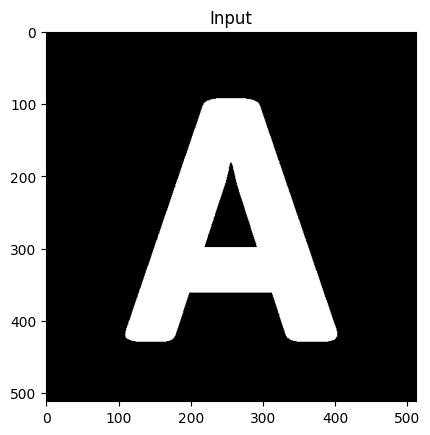

In [ ]:
im = imageio.imread(r"/content/drive/MyDrive/images/letterA.jpg")
# gray = np.mean(im,axis=2)
# threshold = 127
# input = (gray > threshold) * 255
threshold = 127
input = (im > threshold) * 255

input = input.astype(np.uint8)
plt.imshow(input, cmap='gray')
plt.title('Input')
plt.show()




In [ ]:
def loss(phase):
    phase = phase.reshape(input.shape)
    g1 = anp.exp(1j * phase)
    g1ft = anp.fft.fftshift(anp.fft.fft2(anp.fft.ifftshift(g1)))
    return anp.sum(anp.abs(anp.abs(g1ft) ** 2 - anp.abs(input)) ** 2)**2

start_x, start_y = 200,200
region_size = 25
ratios = []
def IFTA(g, N = 100):
    g0 = g

    for i in range(N):
        G = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(g0)))
        G1 = np.sqrt(np.abs(input)) * np.exp(1j * np.angle(G))
        g_ = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(G1)))
        region = G[start_x:start_x + region_size, start_y:start_y + region_size]
        std_dev = np.std(region)
        mean_val = np.mean(region)
        ratio = np.abs(std_dev) / np.abs(mean_val) if mean_val != 0 else 0
        ratios.append(ratio)
        g0 = S * (1 * np.exp(1j * np.angle(g_)))
    return np.angle(g_)

ratios_ = []

def optimization(f, inphase, num=100, step=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = anp.zeros_like(inphase)
    v = anp.zeros_like(inphase)
    t = 0
    phase = inphase
    loss_grad = grad(f)  # Define gradient function outside the loop

    for k in range(num):
        t += 1
        s = loss_grad(phase)  # Compute the gradient

        m = beta1 * m + (1 - beta1) * s
        v = beta2 * v + (1 - beta2) * (s ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        phase = phase - step * m_hat / (anp.sqrt(v_hat) + epsilon)
        gp = S * np.exp(1j * phase)
        Gx = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gp)))
        region = Gx[start_x:start_x + region_size, start_y:start_y + region_size]
        std_dev = np.std(region)
        mean_val = np.mean(region)
        ratio = np.abs(std_dev) / np.abs(mean_val) if mean_val != 0 else 0
        ratios_.append(ratio)
        # print(ratio)

    return phase



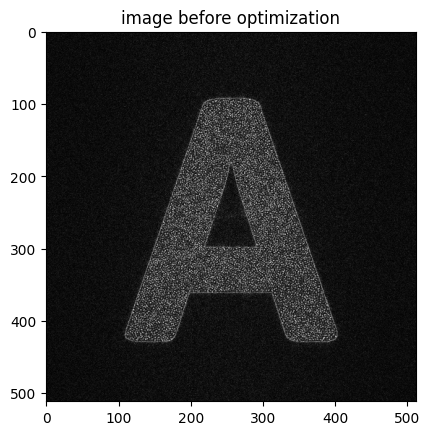

In [ ]:
initial_phase = IFTA(g0_, 100)
field1 = np.exp(1j * initial_phase)
output_image1 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(field1)))
plt.imshow(np.abs(output_image1), cmap="gray")
plt.title("image before optimization")

plt.show()

In [ ]:
x =np.mean(np.abs(output_image1))
print(x)
y = np.mean(input)
print(y)
z = (x-y)/y
print(z)

327.448484664444
48.13642501831055
5.802509420670237


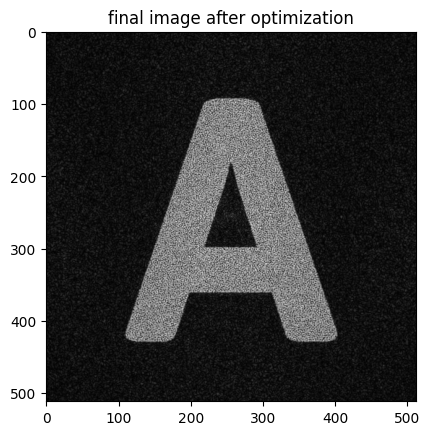

In [ ]:
optimized_phase = optimization(loss, initial_phase)
field = np.exp(1j * optimized_phase) * S
output_image = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(field)))
plt.imshow(np.abs(output_image), cmap="gray")
plt.title("final image after optimization")
plt.show()

In [ ]:
x =np.mean(np.abs(output_image))
print(x)
y = np.mean(input)
print(y)
z = (x-y)/y
print(z)

140.40893079075977
48.13642501831055
1.916895692551946


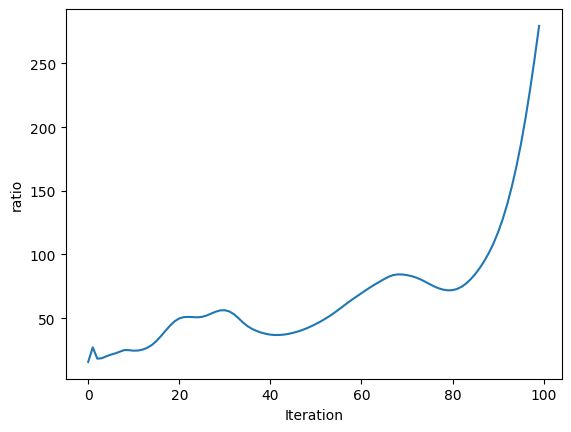

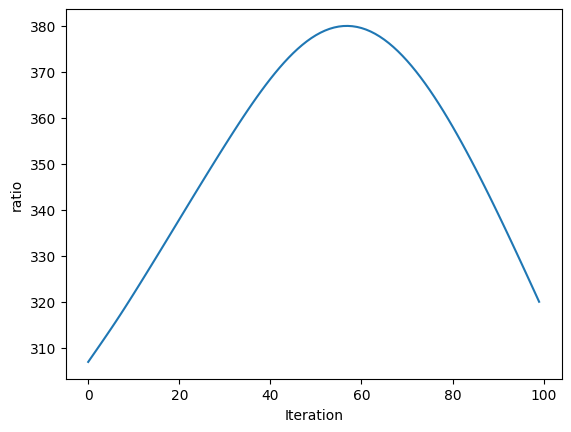

67.59841886027641
352.4564702396905


In [ ]:
plt.plot(ratios)
plt.xlabel('Iteration')
plt.ylabel('ratio')
plt.show()

plt.plot(ratios_)
plt.xlabel('Iteration')
plt.ylabel('ratio')
plt.show()

print(np.mean(ratios))
print(np.mean(ratios_))